## 1.Importing required packages.

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from copy import deepcopy
import time
from itertools import product
# Set random seed for reproducibility
# manual_seed = 999
manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

!mkdir results

Random Seed:  3436
mkdir: cannot create directory ‘results’: File exists


## 2. Download dataset, partition it into trainset, valset, testset.

In [2]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27616097.23it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 431531.67it/s]
  1%|          | 16384/1648877 [00:00<00:11, 146048.82it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 7644807.43it/s]                            
8192it [00:00, 177986.39it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [3]:
print(len(partition["train"]))
print(len(partition["val"]))
print(len(partition["test"]))

50000
10000
10000


## 3. Model of machine. 
Here, I will use MLP for testing. 

In [0]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid() 
        else:
            raise ValueError('no valid activation function selected!')
        
          
    def forward(self, x):
        x = x.view(-1, self.in_dim)
        x = self.act(self.fc1(x))
        for linear in self.linears:
            x = self.act(linear(x))
        x = self.fc2(x)
        return x
            
test_net = MLP(784, 10, 100, 4, 'relu') # Testing Model Construction

## 4. Defining Hyperparameters. 

In [5]:
# Training related
batch_size = 8
test_batch_size = 1000
learning_rate = .07
epoch = 4

# Model related
n_layer = 3
hid_dim = 50
batch_norm = True
act = "relu"

# parser declaration
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.in_dim = 784
args.out_dim = 10
args.batch_size = batch_size
args.test_batch_size = test_batch_size
args.learning_rate = learning_rate
args.epoch = epoch
args.hid_dim = hid_dim
args.n_layer = n_layer
args.act = act

print(args)


Namespace(act='relu', batch_size=8, epoch=4, hid_dim=50, in_dim=784, learning_rate=0.07, n_layer=3, out_dim=10, test_batch_size=1000)


## 5. Defining training related function, train and validate, test.

In [0]:
def train(net, partition, optimizer, criterion, args, is_sgd):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, args.in_dim)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        if is_sgd:
            loss.backward()
            optimizer.step()
        else:
            def closure():
                _predict = net(inputs)
                _loss = criterion(outputs, labels)
                optimizer.zero_grad()
                _loss.backward(retain_graph=True)
                return _loss
            optimizer.step(closure)

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [0]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, args.in_dim)
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [0]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, args.in_dim)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [0]:
def experiment(partition, args):
    
    net_sgd = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net_lbfgs = deepcopy(net_sgd)
    criterion_sgd = nn.CrossEntropyLoss()
    criterion_lbfgs = nn.CrossEntropyLoss()
    optimizer_sgd = torch.optim.SGD(net_sgd.parameters(), lr = args.learning_rate)
    optimizer_lbfgs = torch.optim.LBFGS(net_lbfgs.parameters(), lr = args.learning_rate)
    
    print(args)

    train_losses_sgd = list()
    val_losses_sgd = list()
    train_accs_sgd = list()
    val_accs_sgd = list()
    test_accs_sgd = list()
    train_losses_lbfgs = list()
    val_losses_lbfgs = list()
    train_accs_lbfgs = list()
    val_accs_lbfgs = list()
    test_accs_lbfgs = list()

    
    for epoch in range(args.epoch):
        ts = time.time()
        net_sgd, train_loss, train_acc = train(net_sgd, partition, optimizer_sgd, criterion_sgd, args, True)
        val_loss, val_acc = validate(net_sgd, partition, criterion_sgd, args)
        te = time.time()
        
        print('SGD Epoch {}, Acc(train/val) : {:2.2f}/{:2.2f}, Loss(train/val): {:2.2f}/{:2.2f}. Took {:2.2f} sec.'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
        test_acc = test(net_sgd, partition, args)
        
        train_losses_sgd.append(train_loss)
        val_losses_sgd.append(val_loss)
        train_accs_sgd.append(train_acc)
        val_accs_sgd.append(val_acc)
        test_accs_sgd.append(test_acc)

        ts = time.time()
        net_lbfgs, train_loss, train_acc = train(net_lbfgs, partition, optimizer_lbfgs, criterion_lbfgs, args, False)
        val_loss, val_acc = validate(net_lbfgs, partition, criterion_lbfgs, args)
        te = time.time()

        print('L-BFGS Epoch {}, Acc(train/val) : {:2.2f}/{:2.2f}, Loss(train/val): {:2.2f}/{:2.2f}. Took {:2.2f} sec.'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
        test_acc = test(net_lbfgs, partition, args)
        train_losses_lbfgs.append(train_loss)
        val_losses_lbfgs.append(val_loss)
        train_accs_lbfgs.append(train_acc)
        val_accs_lbfgs.append(val_acc)
        test_accs_lbfgs.append(test_acc)

        
    result = {}
    result['train_losses_sgd'] = train_losses_sgd
    result['train_accs_sgd'] = train_accs_sgd
    result['val_losses_sgd'] = val_losses_sgd
    result['val_accs_sgd'] = val_accs_sgd
    result['test_accs_sgd'] = test_accs_sgd
    
    result['train_losses_lbfgs'] = train_losses_lbfgs
    result['train_accs_lbfgs'] = train_accs_lbfgs
    result['val_losses_lbfgs'] = val_losses_lbfgs
    result['val_accs_lbfgs'] = val_accs_lbfgs
    result['test_accs_lbfgs'] = test_accs_lbfgs
    
    return vars(args), result

## 6. Plotting & Saving experiment result

In [0]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)
    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

## 7. Experiments

Experiment will be as follows. 

1.   Dataset is MNIST, and our model is MLP. 
2.   First, we will randomly generate MLP model for each layer number and size of layer. And clone it so that we have same initial model for SGD and L-BFGS.
3.   For various learning rate, run experiment.


### Experiment 1. Choosing Model of MLP

In [11]:
args.exp_name = "exp"

name_var1 = 'n_layer'
name_var2 = 'hid_dim'
name_var3 = 'learning_rate'
list_var1 = [1, 3]
list_var2 = [100, 300]
list_var3 = [0.1, 0.01, 0.001]
"""
setattr(args, "n_layer", 5)
setattr(args, "hid_dim", 500)
print(args)

setting, result = experiment(partition, deepcopy(args))
save_exp_result(setting, result)
"""
for var_list in product(list_var1, list_var2, list_var3):
    setattr(args, name_var1, var_list[0])
    setattr(args, name_var2, var_list[1])
    setattr(args, name_var3, var_list[2])
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

Namespace(act='relu', batch_size=8, epoch=4, exp_name='exp', hid_dim=100, in_dim=784, learning_rate=0.1, n_layer=1, out_dim=10, test_batch_size=1000)
SGD Epoch 0, Acc(train/val) : 10.82/9.64, Loss(train/val): 16.73/31.08. Took 19.32 sec.
L-BFGS Epoch 0, Acc(train/val) : 72.64/73.35, Loss(train/val): 0.88/0.84. Took 187.51 sec.
SGD Epoch 1, Acc(train/val) : 9.90/9.64, Loss(train/val): 24.27/37.18. Took 18.76 sec.
L-BFGS Epoch 1, Acc(train/val) : 73.91/73.35, Loss(train/val): 0.84/0.84. Took 183.19 sec.
SGD Epoch 2, Acc(train/val) : 9.92/10.00, Loss(train/val): 37.72/40.06. Took 19.48 sec.
L-BFGS Epoch 2, Acc(train/val) : 73.91/73.35, Loss(train/val): 0.84/0.84. Took 171.01 sec.
SGD Epoch 3, Acc(train/val) : 9.95/9.75, Loss(train/val): 39.76/56.17. Took 18.89 sec.
L-BFGS Epoch 3, Acc(train/val) : 73.91/73.35, Loss(train/val): 0.84/0.84. Took 178.93 sec.
Namespace(act='relu', batch_size=8, epoch=4, exp_name='exp', hid_dim=100, in_dim=784, learning_rate=0.01, n_layer=1, out_dim=10, test_ba

## 8. Result Visualizing

In [37]:
loss_dict = dict()

for lr in [.1, .01, .001]:
    for n_l in [1, 3]:
        for h_d in [100, 300]:
            row = df.loc[df['learning_rate']==lr]
            row = row.loc[df['n_layer']==n_l]
            row = row.loc[df['hid_dim']==h_d]
            row = row.loc[df['batch_size']==8]
            dl = list()
            for d in row.train_losses_sgd:
                dl.append(d)
            loss_dict[(lr, n_l, h_d, 'sgd')] = ([0, 1, 2, 3], dl)
            dl = list()
            for d in row.train_losses_lbfgs:
                dl.append(d)
            loss_dict[(lr, n_l, h_d, 'lbfgs')] = ([0, 1, 2, 3], dl)

loss_dict

{(0.001, 1, 100, 'lbfgs'): ([0, 1, 2, 3],
  [[2.29846644115448,
    2.298466439208984,
    2.2984664386367797,
    2.2984664376449584]]),
 (0.001, 1, 100, 'sgd'): ([0, 1, 2, 3],
  [[1.976708996157968,
    2.5701947753429413,
    2.7425695468330384,
    2.5085428927993774]]),
 (0.001, 1, 300, 'lbfgs'): ([0, 1, 2, 3],
  [[2.317513458595276,
    2.3175134581375123,
    2.3175134601974485,
    2.3175134596633913]]),
 (0.001, 1, 300, 'sgd'): ([0, 1, 2, 3],
  [[1.5504882510974072,
    2.3927955853462217,
    2.5410263397407533,
    3.0143776584625246]]),
 (0.001, 3, 100, 'lbfgs'): ([0, 1, 2, 3],
  [[2.304394744415283,
    2.3043947451400757,
    2.3043947453689575,
    2.304394744987488]]),
 (0.001, 3, 100, 'sgd'): ([0, 1, 2, 3],
  [[2.4829793995276837,
    2.743692381248474,
    2.632054255237579,
    2.8775174335479736]]),
 (0.001, 3, 300, 'lbfgs'): ([0, 1, 2, 3],
  [[2.3033262620544432,
    2.3033262605285643,
    2.303326259307861,
    2.303326259765625]]),
 (0.001, 3, 300, 'sgd'): ([0, 

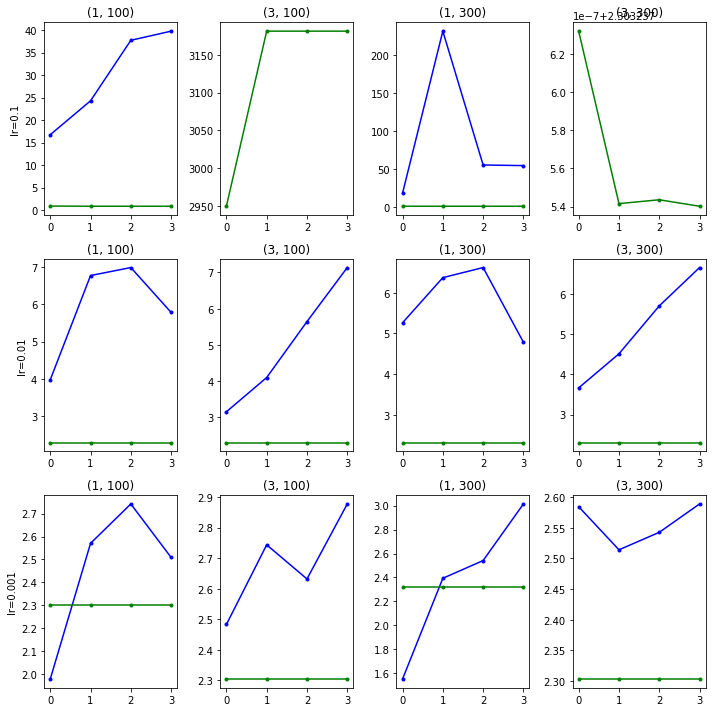

In [54]:
plt.rcParams["figure.figsize"] = (10, 10)
for i in range(4):
    for j in range(3):
        plt.subplot(3, 4, 4 * j + i + 1)
        plt.plot([0, 1, 2, 3], loss_dict[([.1, .01, .001][j], [1, 3][i % 2], [100, 300][i // 2], 'sgd')][1][0], '.-b')
        plt.plot([0, 1, 2, 3], loss_dict[([.1, .01, .001][j], [1, 3][i % 2], [100, 300][i // 2], 'lbfgs')][1][0], '.-g')
        plt.title("({}, {})".format([1, 3][i % 2], [100, 300][i // 2]))
        if i==0:
            plt.ylabel("lr={}".format([.1, .01, .001][j]))
plt.tight_layout()
#plt.set_xlabel("(n_layer, hid_dim)")
#plt.set_ylabel("learning rate")
plt.show()